# Fair Market Rates analysis tool

In [1]:
import fetchData
import transformData
import pandas as pd
import analyze
import matplotlib.pyplot as plt
# import importlib
# importlib.reload(analyze)
# importlib.reload(transformData)
# importlib.reload(fetchData)

## Data Preparation

In [2]:
API_file = 'API_Config.ini'
BLS_area_codes = 'Data/BLS/cu.area.txt'
analysis_start_year = 2014
analysis_end_year = 2024
FMR_implementation_month = 10

### Loading the list of metro areas from BLS

Loading the list of metro areas whose CPI data is present in the Bureau of Labour Statistics database

In [3]:
#fetching series id's for every metro area available in the Bureau of Labour Statistic's database
series_id = fetchData.get_bls_series_id(metro_code_file=BLS_area_codes)
series_id.head()

,area_code,area_name,area_state
1,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH
2,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA
3,CUURS12BSA0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD
5,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI
6,CUURS23BSA0,Detroit-Warren-Dearborn,MI


In [4]:
series_id.isna().sum()

area_code     0
area_name     0
area_state    0
dtype: int64

The dataset has no missing values

#### Cleaning the CPI Data

In [5]:
series_id['area_state'].unique()

<StringArray>
[      'MA-NH',    'NY-NJ-PA', 'PA-NJ-DE-MD',    'IL-IN-WI',          'MI',
       'MN-WI',       'MO-IL', 'DC-VA-MD-WV',          'FL',          'GA',
          'MD',          'TX',          'AZ',          'CO',          'CA',
          'WA',      'Hawaii',      'Alaska']
Length: 18, dtype: string

On further inspection, there are some rows for which the state names [Hawaii and Alaska] are not abbreviated. This can later cause an issue while merging this dataset with the HUD dataset.

In [6]:
series_id.loc[series_id['area_state'] == 'Hawaii','area_state'] = 'HI'
series_id.loc[series_id['area_state'] == 'Alaska','area_state'] = 'AK'
series_id['area_state'].unique()

<StringArray>
[      'MA-NH',    'NY-NJ-PA', 'PA-NJ-DE-MD',    'IL-IN-WI',          'MI',
       'MN-WI',       'MO-IL', 'DC-VA-MD-WV',          'FL',          'GA',
          'MD',          'TX',          'AZ',          'CO',          'CA',
          'WA',          'HI',          'AK']
Length: 18, dtype: string

After processing, the dataframe has no missing / incorrect values.

### Loading the list of metro areas from HUD

Loading the list of metro areas whose FMR data is available in the HUD database

In [7]:
hud_metro_data = fetchData.get_metro_codes_hud(api_config=API_file)
hud_metro_data.head()

,cbsa_code,area_name,area_state
0,METRO10180M10180,Abilene,TX
1,METRO29180N22001,Acadia Parish,LA
2,METRO10380M10380,Aguadilla-Isabela,PR
3,METRO10420M10420,Akron,OH
4,METRO10500M10500,Albany,GA


In [8]:
hud_metro_data.isna().sum()

cbsa_code     0
area_name     0
area_state    0
dtype: int64

This dataset has no missing values.

#### Cleaning the FMR data

In [9]:
hud_metro_data['area_state'].unique()

<StringArray>
[          'TX',           'LA',           'PR',           'OH',
           'GA',           'OR',           'NY',           'NM',
           'KY',           'PA',           'IA',           'AK',
           'IN',           'SC',           'MI',           'AL',
           'WI',           'NC',           'NJ',        'GA-SC',
           'FL',           'CA',           'MD',           'ME',
           'MA',           'MO',           'WA',           'MS',
           'MT',           'ND',           'VA',           'IL',
           'ID',           'WV',        'MA-NH',           'CO',
           'UT',           'CT',           'VT',           'TN',
        'MO-IL',           'NV',           'WY',        'NC-SC',
        'TN-GA',     'OH-KY-IN',        'TN-KY',        'GA-AL',
           'OK',        'MD-WV',           'SD',        'IA-IL',
           'DE',        'MN-WI',        'IN-KY',        'ND-MN',
           'AR',           'MN',           'AZ',        'AR-OK',
           

On further inspection, there is a row for which the state name [TX-Texarkana] is not correct. This can later cause an issue while merging this dataset with the BLS dataset.

In [10]:
hud_metro_data.loc[hud_metro_data['area_state'] == 'TX-Texarkana', 'area_state'] = 'TX'

After processing, the dataframe has no missing / incorrect values.

### Merging the BLS and HUD datasets

Merging the two datasets to get the metro areas for which both the CPI and FMR data is available.

In [11]:
merge_data = pd.merge(series_id, hud_metro_data, on='area_name', how='left', suffixes=('_BLS', '_HUD'))
merge_data.isna().sum()

area_code          0
area_name          0
area_state_BLS     0
cbsa_code         12
area_state_HUD    12
dtype: int64

There are 12 rows from the BLS dataset that have no corresponding metro area in the HUD dataset. Ideally that should not be the case, HUD's database is quite extensive.

In [12]:
merge_data[merge_data['cbsa_code'].isna()]

,area_code,area_name,area_state_BLS,cbsa_code,area_state_HUD
0,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH,<NA>,<NA>
1,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA,<NA>,<NA>
3,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI,<NA>,<NA>
4,CUURS23BSA0,Detroit-Warren-Dearborn,MI,<NA>,<NA>
5,CUURS24ASA0,Minneapolis-St.Paul-Bloomington,MN-WI,<NA>,<NA>
8,CUURS35BSA0,Miami-Fort Lauderdale-West Palm Beach,FL,<NA>,<NA>
12,CUURS37ASA0,Dallas-Fort Worth-Arlington,TX,<NA>,<NA>
16,CUURS49ASA0,Los Angeles-Long Beach-Anaheim,CA,<NA>,<NA>
17,CUURS49BSA0,San Francisco-Oakland-Hayward,CA,<NA>,<NA>
19,CUURS49DSA0,Seattle-Tacoma-Bellevue,WA,<NA>,<NA>


In [13]:
hud_metro_data[hud_metro_data['area_name'].str.contains('Boston')]

,cbsa_code,area_name,area_state
61,METRO14460MM1120,Boston-Cambridge-Quincy,MA-NH


On further investigation, it is observed that the issue is arising due to some slight difference in the names. In this case, either the data from HUD or BLS is not correctly named. The names should not be different as they both are based on 'cbsa' codes. To resolve this, we can try to find the best possible match and proceed accordingly. If no match is found, then that row will be dropped.

In [14]:
unmatched_indices = merge_data[merge_data['cbsa_code'].isna()].index
unmatched_areas_metro = list(merge_data['area_name'][merge_data['cbsa_code'].isna()].apply(lambda x: x.split('-')[0]))
unmatched_dict = dict(zip(unmatched_indices, unmatched_areas_metro))
for i in unmatched_indices:
    hud_area = hud_metro_data[hud_metro_data['area_name'].str.contains(unmatched_dict[i])]
    if len(hud_area) > 1:
        hud_area = hud_area[hud_area['area_state'] == merge_data['area_state_BLS'].loc[i]]
    if len(hud_area) == 1:
        merge_data.loc[i, 'cbsa_code'] = hud_area['cbsa_code'][hud_area['area_name'].str.contains(unmatched_dict[i])].values
merge_data[merge_data['cbsa_code'].isna()]

,area_code,area_name,area_state_BLS,cbsa_code,area_state_HUD
22,CUURS49GSA0,Urban,AK,<NA>,<NA>


In [15]:
merge_data = merge_data.dropna(subset=['cbsa_code']).drop(columns=['area_state_HUD']).rename(columns={'area_state_BLS': 'area_state'})

One row (Urban Alaska) is dropped as there is no corresponding metro area in the HUD dataset.

### Loading zipcode data

In [16]:
zipcode_data = pd.read_csv('Data/Processed Data/zipcode_fmrs.csv', dtype={'ZIPCODE':'string', 'Efficiency':'Float32', 'One-Bedroom':'Float32', 'Two-Bedroom':'Float32', 'Three-Bedroom':'Float32',
       'Four-Bedroom':'Float32', 'Date':'string', 'Metro_Codes': 'string'})
zipcode_data['Date'] = pd.to_datetime(zipcode_data['Date'])
zipcode_data['Mean_Rent'] = zipcode_data[['Efficiency', 'One-Bedroom', 'Two-Bedroom', 'Three-Bedroom', 'Four-Bedroom']].mean(axis=1)
zipcode_data

,ZIPCODE,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,Date,Metro_Codes,Mean_Rent
0,00602,320.0,340.0,400.0,560.0,620.0,2014-10-01,METRO10380M10380,448.0
1,00603,340.0,350.0,420.0,590.0,650.0,2014-10-01,METRO10380M10380,470.0
2,00606,310.0,320.0,380.0,530.0,615.0,2014-10-01,METRO41900M41900,431.0
3,00606,310.0,320.0,380.0,530.0,615.0,2014-10-01,METRO49500M49500,431.0
4,00610,300.0,310.0,370.0,520.0,570.0,2014-10-01,METRO10380M10380,414.0
...,...,...,...,...,...,...,...,...,...
247330,99712,920.0,1030.0,1350.0,1900.0,2290.0,2024-10-01,METRO21820M21820,1498.0
247331,99714,1240.0,1390.0,1830.0,2580.0,3110.0,2024-10-01,METRO21820M21820,2030.0
247332,99729,920.0,970.0,1280.0,1800.0,2170.0,2024-10-01,METRO11260N02170,1428.0
247333,99760,1120.0,1260.0,1650.0,2330.0,2800.0,2024-10-01,METRO21820M21820,1832.0


## Identifying Lag in CPI and FMR

### Selecting a metro area for analysis

In [17]:
print('following is the list of available metro_areas:')
merge_data.head(100)

following is the list of available metro_areas:


,area_code,area_name,area_state,cbsa_code
0,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH,METRO14460MM1120
1,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA,METRO35620MM5600
2,CUURS12BSA0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,METRO37980M37980
3,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI,METRO16980M16980
4,CUURS23BSA0,Detroit-Warren-Dearborn,MI,METRO19820M19820
5,CUURS24ASA0,Minneapolis-St.Paul-Bloomington,MN-WI,METRO33460M33460
6,CUURS24BSA0,St. Louis,MO-IL,METRO41180M41180
7,CUURS35ASA0,Washington-Arlington-Alexandria,DC-VA-MD-WV,METRO47900M47900
8,CUURS35BSA0,Miami-Fort Lauderdale-West Palm Beach,FL,METRO33100MM5000
9,CUURS35CSA0,Atlanta-Sandy Springs-Roswell,GA,METRO12060M12060


In [18]:
metro_index = fetchData.select_area(merge_data, region='metro')

San Diego-Carlsbad has been selected


### Loading State data for the selected metro area

In [19]:
state_code = merge_data['area_state'].iloc[int(metro_index)].split('-')[0]
state_code

'CA'

In [20]:
state_data = fetchData.fetch_state_fmr_data(api_config=API_file, start_year=analysis_start_year, end_year=analysis_end_year, state_code=state_code, implementation_month=FMR_implementation_month)
state_data.head()

,code,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,Date
0,METRO12540M12540,623.0,650.0,844.0,1222.0,1470.0,2017-10-01
1,METRO17020M17020,656.0,729.0,923.0,1344.0,1614.0,2017-10-01
2,METRO20940M20940,522.0,626.0,822.0,1123.0,1434.0,2017-10-01
3,METRO23420M23420,670.0,709.0,887.0,1258.0,1470.0,2017-10-01
4,METRO25260M25260,619.0,623.0,803.0,1133.0,1296.0,2017-10-01


### Loading CPI data for the selected metro area

In [21]:
cpi_id = merge_data['area_code'].iloc[int(metro_index)]
cpi_id

'CUURS49ESA0'

In [22]:
cpi_data = fetchData.fetch_metro_cpi_bls(api_config=API_file, area_code=cpi_id, start_year=analysis_start_year, end_year=analysis_end_year)
cpi_data.head()

Month,01,03,05,07,09,11
year,,,,,,
2017,<NA>,<NA>,<NA>,<NA>,<NA>,285.960999
2018,288.330994,290.809998,289.243011,295.184998,295.882996,293.858002
2019,295.760986,297.226013,300.303009,299.333008,301.03299,301.519989
2020,302.563995,302.588989,301.316986,305.610992,304.442993,306.334015
2021,307.687988,315.035004,317.140991,323.906006,324.138,326.421997


### Loading FMR data for the selected metro area

In [23]:
cbsa_code = merge_data['cbsa_code'].iloc[int(metro_index)]
cbsa_code

'METRO41740M41740'

In [24]:
cbsa_data = state_data[state_data['code'] == cbsa_code].reset_index(drop=True)
cbsa_data.head()

,code,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,Date
0,METRO41740M41740,1212.0,1342.0,1741.0,2507.0,3068.0,2017-10-01
1,METRO41740M41740,1257.0,1400.0,1816.0,2612.0,3198.0,2018-10-01
2,METRO41740M41740,1333.0,1490.0,1938.0,2776.0,3404.0,2019-10-01
3,METRO41740M41740,1404.0,1566.0,2037.0,2894.0,3576.0,2020-10-01
4,METRO41740M41740,1478.0,1642.0,2124.0,2987.0,3677.0,2021-10-01


### Smoothing CPI data

In [25]:
cpi_data_transformed = transformData.transform_cpi_data(cpi_data)
cpi_data_transformed.head()

,CPI
Date,
2017-11-01,285.960999
2018-01-01,288.330994
2018-03-01,290.809998
2018-05-01,289.243011
2018-07-01,295.184998


In [26]:
metro = transformData.smooth_and_merge(fmr=cbsa_data, cpi=cpi_data_transformed, start_month=FMR_implementation_month)
metro.head()

,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,Mean_Rent,CPI
Date,,,,,,,
2017-10-01,1212.0,1342.0,1741.0,2507.0,3068.0,1693.483765,290.902161
2018-10-01,1257.0,1400.0,1816.0,2612.0,3198.0,1763.48645,297.919006
2019-10-01,1333.0,1490.0,1938.0,2776.0,3404.0,1874.001343,303.007324
2020-10-01,1404.0,1566.0,2037.0,2894.0,3576.0,1965.451172,315.707001
2021-10-01,1478.0,1642.0,2124.0,2987.0,3677.0,2041.359741,340.158173


### calculating Percentage change

In [27]:
combined_pct_std = metro.pct_change()
# combined_pct_std = (combined_pct_std - combined_pct_std.min()) / (combined_pct_std.max() - combined_pct_std.min())
combined_pct_std = (combined_pct_std - combined_pct_std.mean())/combined_pct_std.std()
combined_pct_std.columns

Index(['Efficiency', 'One-Bedroom', 'Two-Bedroom', 'Three-Bedroom',
       'Four-Bedroom', 'Mean_Rent', 'CPI'],
      dtype='object')

### Calculating lag period

The lag between the free market rate implemented and the consumer price index is:  2
The correlation Mean_Rent and consumer price index, after a 2 year lag is: 0.91


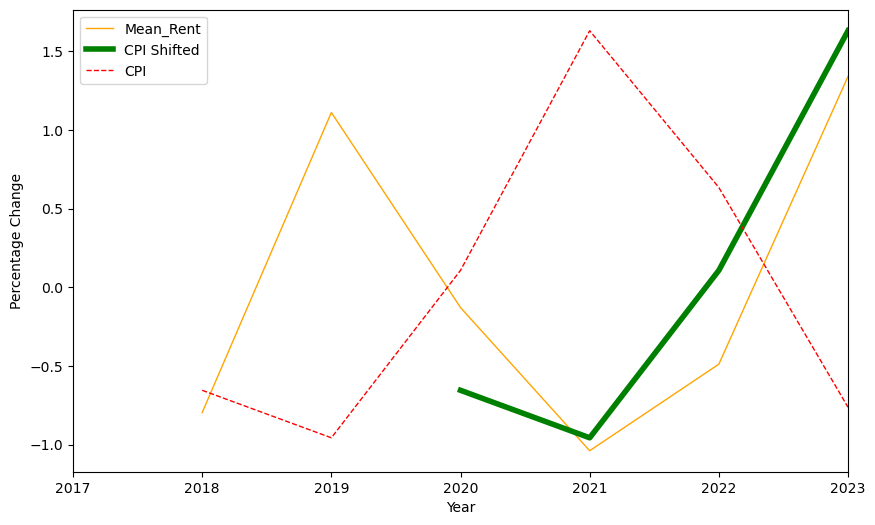

In [28]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Mean_Rent')

The lag between the free market rate implemented and the consumer price index is:  2
The correlation Efficiency and consumer price index, after a 2 year lag is: 0.99


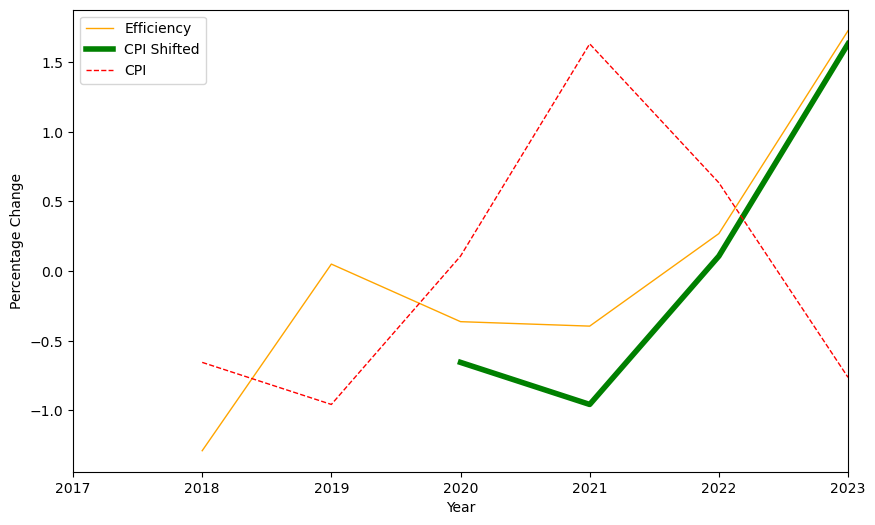

In [29]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Efficiency')

The lag between the free market rate implemented and the consumer price index is:  2
The correlation One-Bedroom and consumer price index, after a 2 year lag is: 0.99


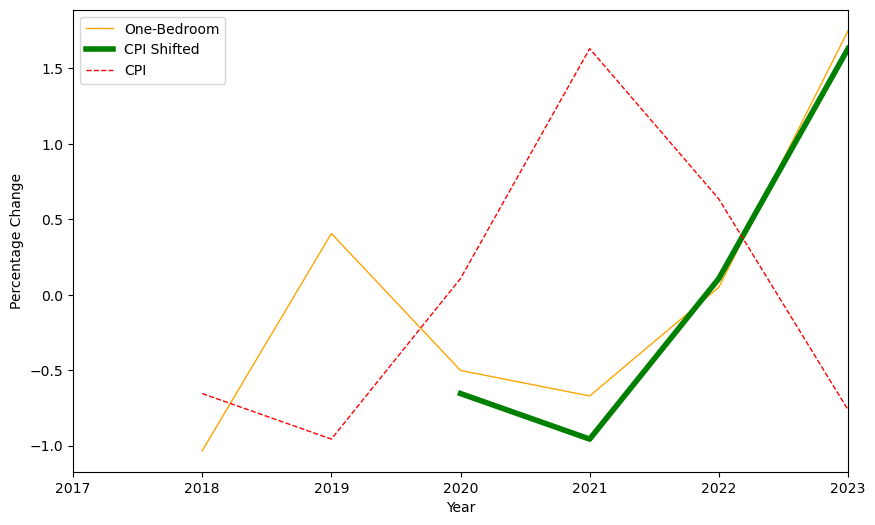

In [30]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='One-Bedroom')

The lag between the free market rate implemented and the consumer price index is:  2
The correlation Two-Bedroom and consumer price index, after a 2 year lag is: 0.96


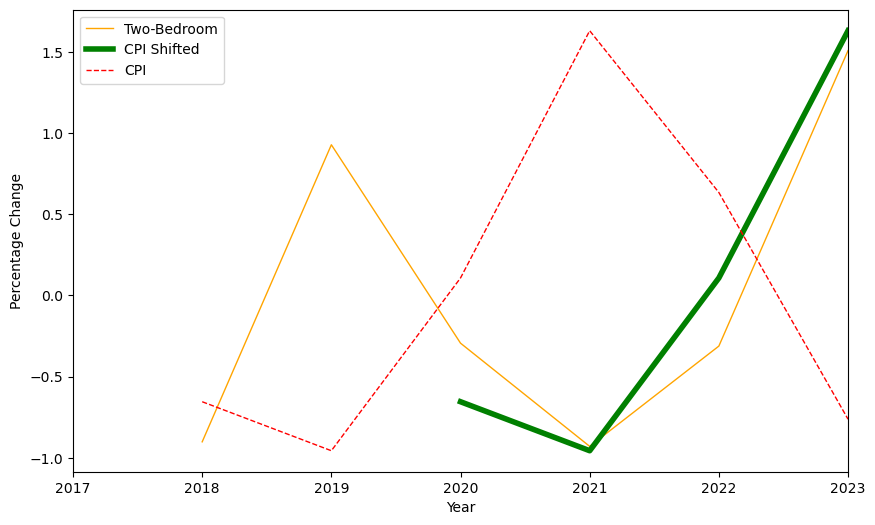

In [31]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Two-Bedroom')

The lag between the free market rate implemented and the consumer price index is:  2
The correlation Three-Bedroom and consumer price index, after a 2 year lag is: 0.9


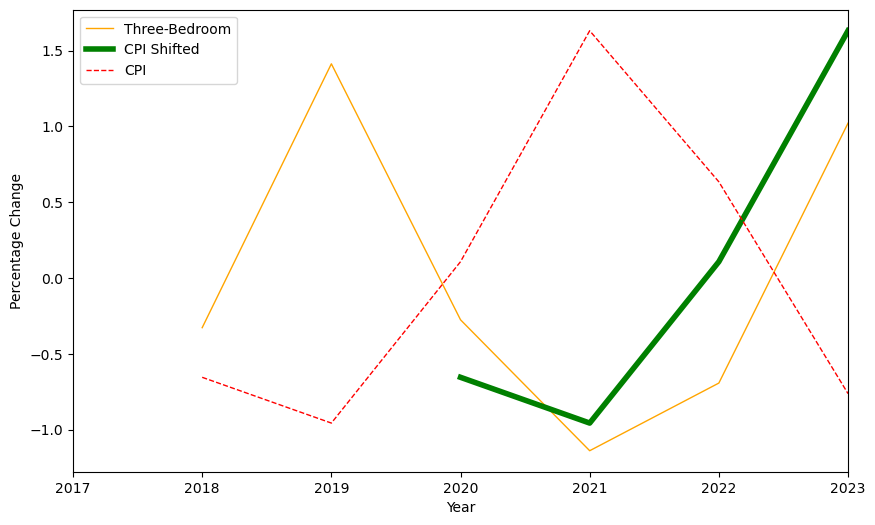

In [32]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Three-Bedroom')

The lag between the free market rate implemented and the consumer price index is:  3
The correlation Four-Bedroom and consumer price index, after a 3 year lag is: 0.91


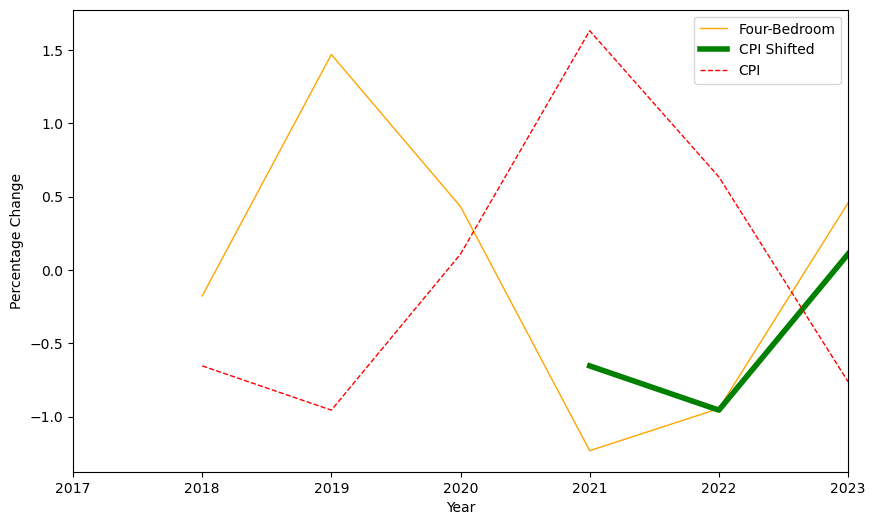

In [33]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Four-Bedroom')

In some cases, the correlation for lag = 3 years can be marginally better than the correlation for lag = 2 years. A slightly better correlation does not conclude that the lag = 3 years. As the remaining apartment types have exhibited a lag of 2 years, it is advisable to check the trends for that lag period.

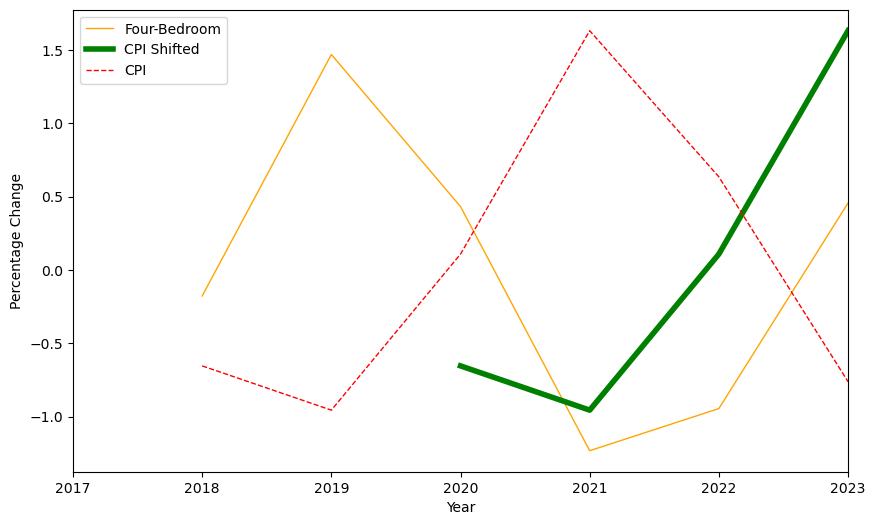

In [34]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Four-Bedroom', estimated_lag=2, use_estimate=True)

For lag = 2 years the trend line for rent matches the shape of the trend line for consumer price index, and as all other apartment types have also exhibited a lag of 2 years, it can be concluded that the 'fair market rates' for this metro area are correlated with the consumer price index and the effect is visible after 2 years. Hence, Hypothesis 1 is proven.

#### Plotting Lag for all types of apartments

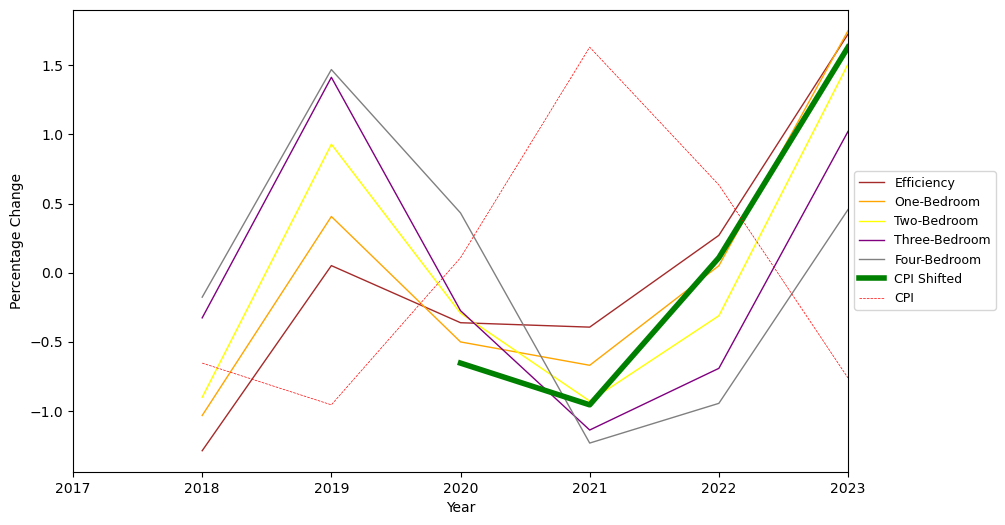

In [35]:
shift_data = combined_pct_std.copy()
shift_data['CPI'] = shift_data['CPI'].shift(2)
shift_data.rename(columns={'CPI':'CPI Shifted'}, inplace=True)
shift_data.drop(columns=['Mean_Rent', 'CPI Shifted']).plot.line(figsize=(10, 6), linewidth=1, color=['brown', 'orange', 'yellow', 'purple', 'grey'], legend=True)
shift_data['CPI Shifted'].plot.line(figsize=(10, 6), linewidth=4, color='green', legend=True)
combined_pct_std['CPI'].plot.line(figsize=(10, 6), linewidth=0.5, color='red', legend=True, linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), fontsize = 9)
plt.show()

## Studying individual zipcodes in the metro area

In [36]:
# keeping jus the metro data
zipcode_data_metro = zipcode_data[zipcode_data['Metro_Codes'] ==  cbsa_code].drop(columns=['Metro_Codes']).reset_index(drop=True)
zipcode_data_metro.sort_values(['Date', 'ZIPCODE'], ascending=True, inplace=True)
zipcode_data_metro.head()

,ZIPCODE,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,Date,Mean_Rent
0,91901,980.0,1080.0,1410.0,2050.0,2500.0,2014-10-01,1604.0
1,91902,1120.0,1230.0,1610.0,2340.0,2850.0,2014-10-01,1830.0
2,91905,570.0,630.0,820.0,1190.0,1450.0,2014-10-01,932.0
3,91906,710.0,790.0,1030.0,1500.0,1820.0,2014-10-01,1170.0
4,91908,940.0,1030.0,1350.0,1960.0,2390.0,2014-10-01,1534.0


### Identify Outliers

In [37]:
zips = analyze.zipcodes_trends(zipcode_data_metro, field_to_analyze='Mean_Rent')

In [38]:
zips[(zips['Above STD'] !=0 ) | (zips['Below STD'] != 0)]

,ZIPCODE,Above STD,Below STD,Total,Mean_growth_rate
0,91931,3,2,5,0.213810
1,91916,3,1,4,0.169973
2,91905,2,2,4,0.191012
3,92070,2,2,4,0.124258
4,92061,2,1,3,0.138523
5,92091,2,1,3,0.130025
6,92134,2,1,3,0.102162
7,92004,1,2,3,0.071387
8,91906,1,1,2,0.076650
9,92055,1,1,2,0.107195


The 'total' column indicates the number of years when the rents in the zip code had exhibited a growth rate which as 2 standard deviations away from the mean growth rate of the rent for the metro area. 'Above STD' column indicates the number of years when the rent in the zip code had a growth rate which more than 2 standard deviation from the mean growth rate, and similarly the 'Below STD' column indicates the number of years when it was 2 standard deviations lower than the mean growth rate.

In [39]:
zips[(zips['Above STD'] ==0 ) & (zips['Below STD'] == 0)]

,ZIPCODE,Above STD,Below STD,Total,Mean_growth_rate
31,91901,0,0,0,0.067254
32,91902,0,0,0,0.065723
33,91908,0,0,0,0.075723
34,91910,0,0,0,0.072597
35,91911,0,0,0,0.072940
...,...,...,...,...,...
135,92191,0,0,0,0.075723
136,92193,0,0,0,0.075723
137,92195,0,0,0,0.075723
138,92196,0,0,0,0.075723


The above table represents the zip codes where the change in housing rent was in line with the trend in the metropolitan area.

### Selecting A zip code

In [40]:
zip_index = fetchData.select_area(zips, region='zip')

92070 has been selected


In [41]:
zipcode = zips['ZIPCODE'].loc[int(zip_index)]
field_to_analyze = 'Mean_Rent'

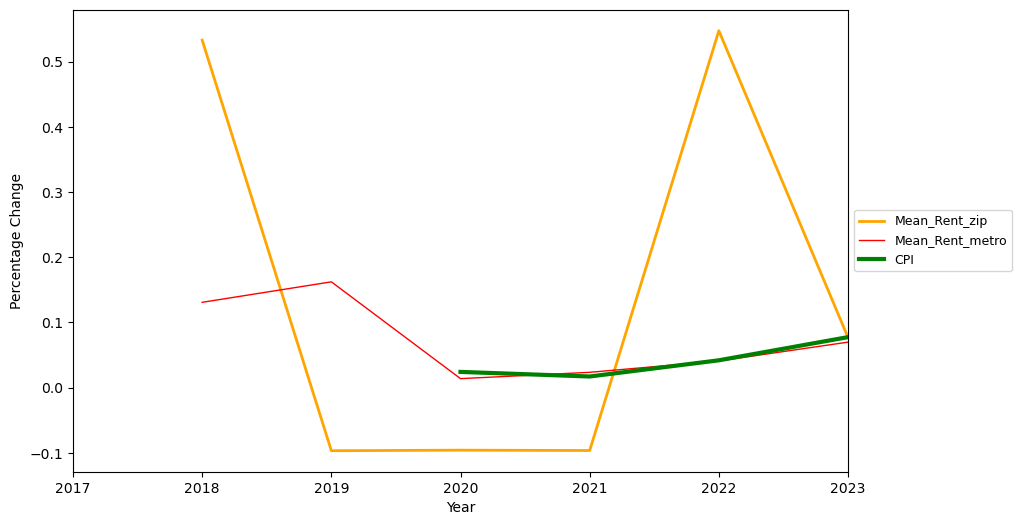

In [42]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze=field_to_analyze, fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

Zip code '92070' had 2 years when the percentage change in rents was much higher as compared to the metro area, and it had two years when it was much lower than the metro area. From 2019 to 2021, the area experienced a decrease in the rents which both the rent in the metropolitan and the consumer price index had some growth. Conversely, in 2018 and 2022, the area experienced a massive hike in rents as compared to the metropolitan area.

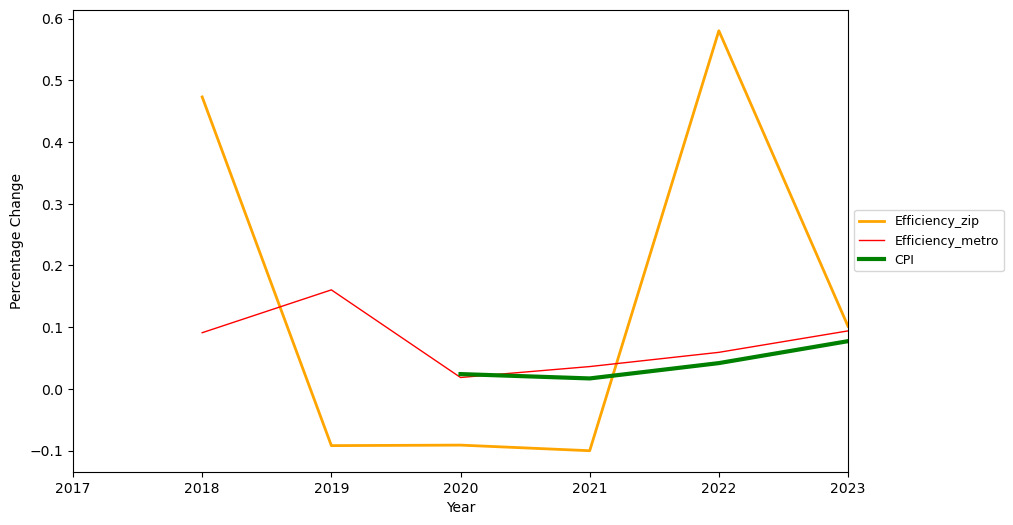

In [43]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='Efficiency', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

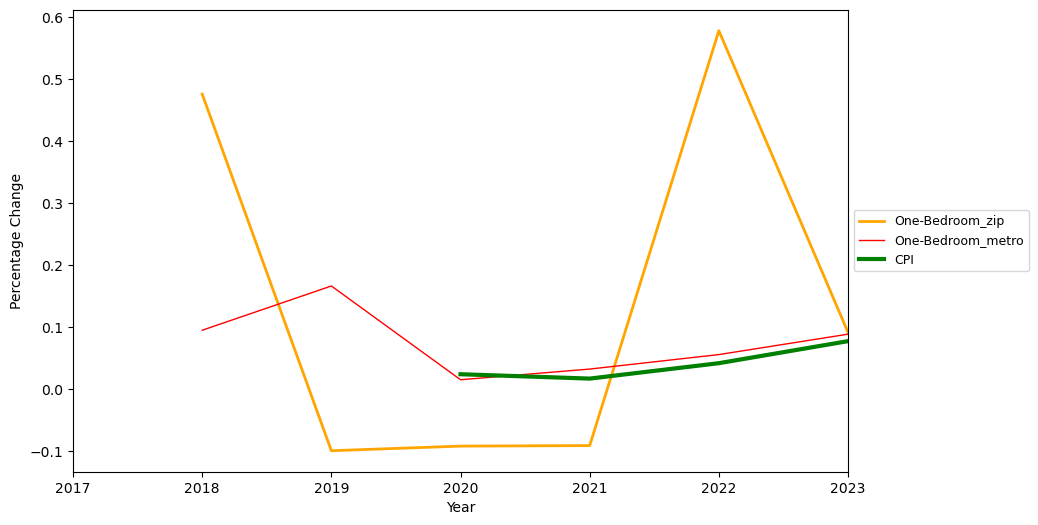

In [44]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='One-Bedroom', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

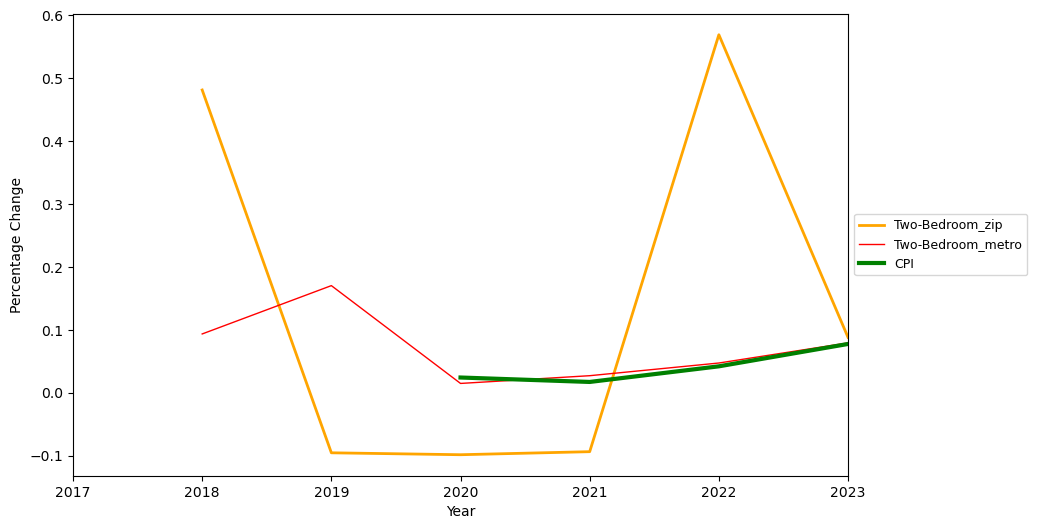

In [45]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='Two-Bedroom', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

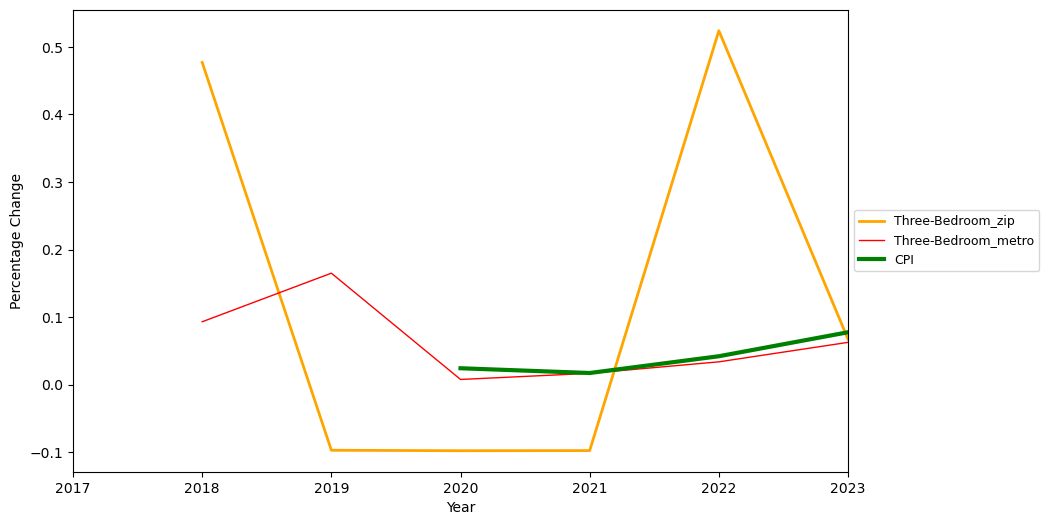

In [46]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='Three-Bedroom', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

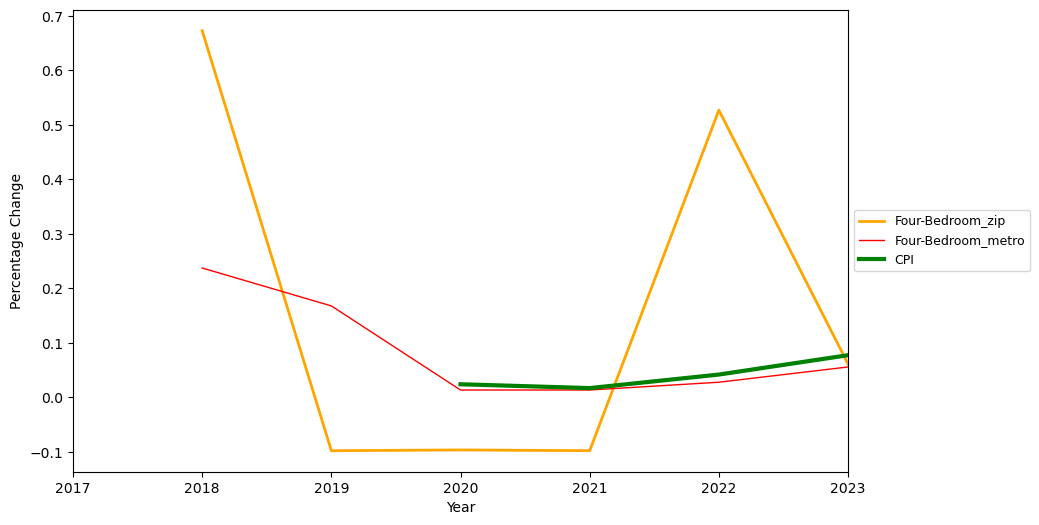

In [47]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='Four-Bedroom', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

### Selecting another zip code

In [48]:
zip_index = fetchData.select_area(zips, region='zip')

91944 has been selected


In [49]:
zipcode = zips['ZIPCODE'].loc[int(zip_index)]
field_to_analyze = 'Mean_Rent'

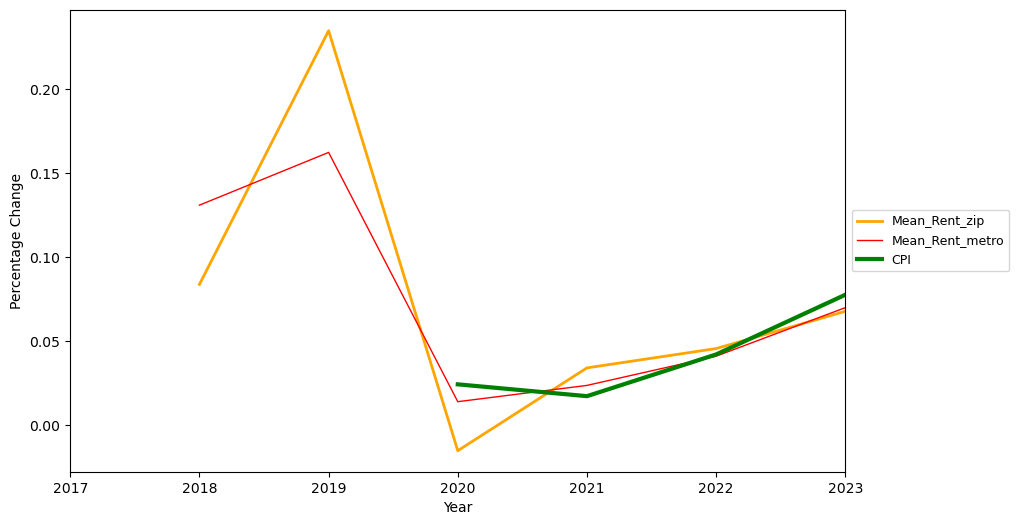

In [50]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze=field_to_analyze, fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

The trend for percentage change in rents in zip code '91944' is in line with the trend in consumer price index and the trend in percentage change in rents for the entire metropolitan area.

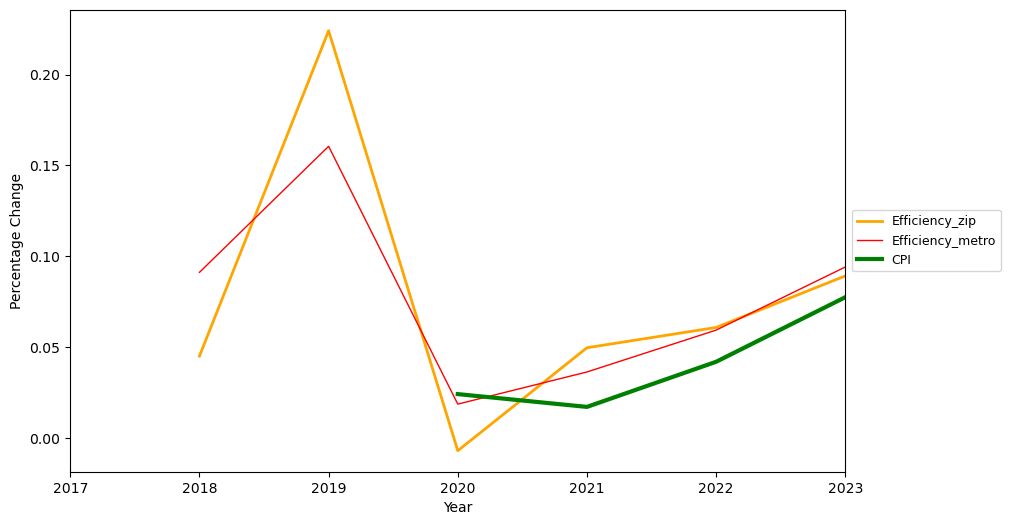

In [51]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='Efficiency', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

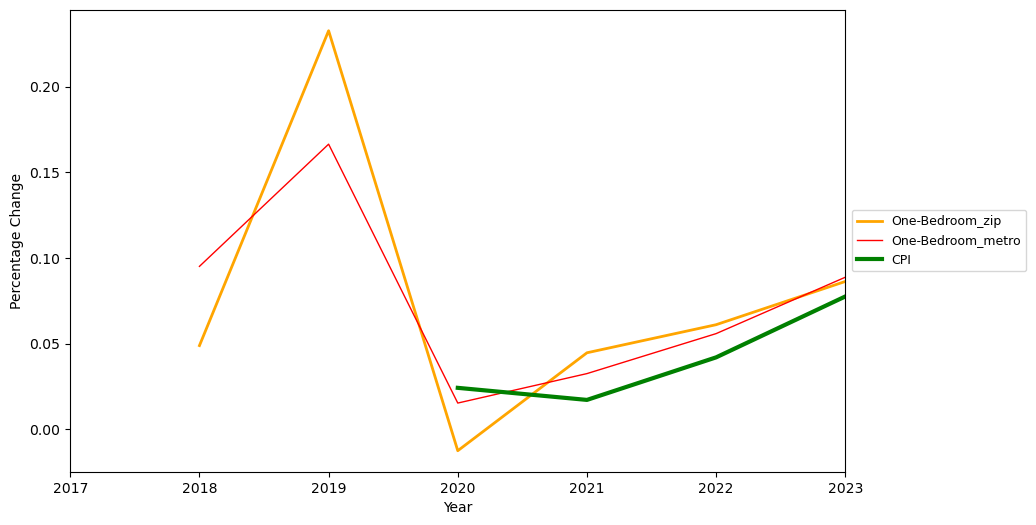

In [52]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='One-Bedroom', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

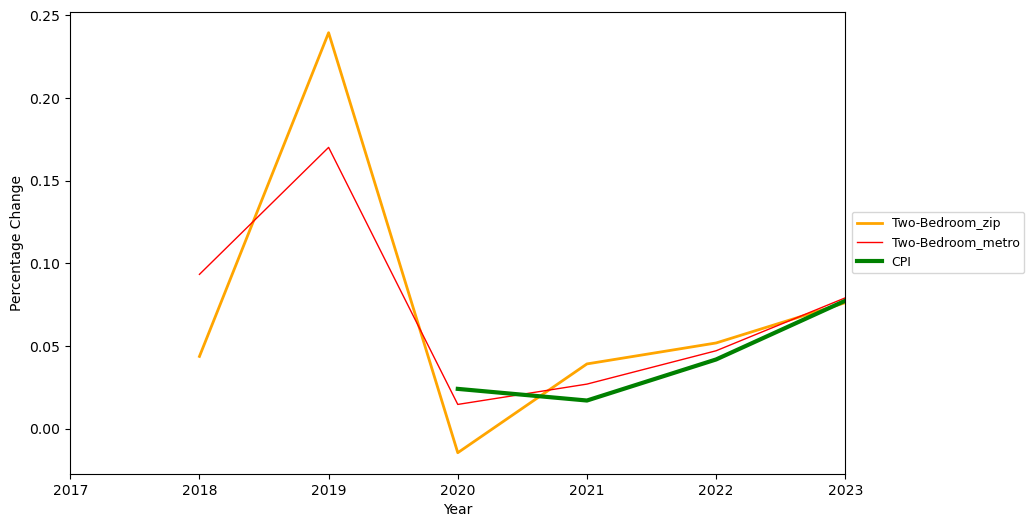

In [53]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='Two-Bedroom', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

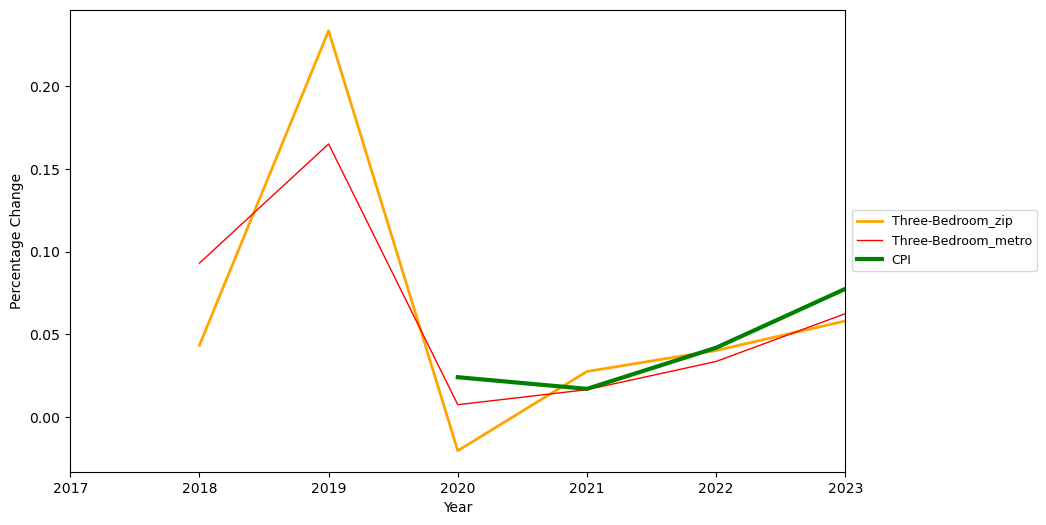

In [54]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='Three-Bedroom', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

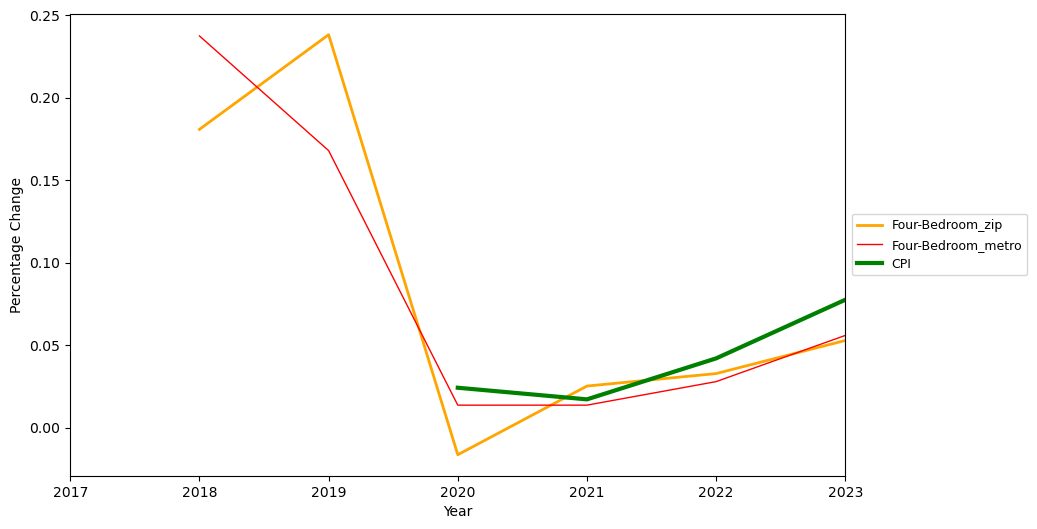

In [55]:
analyze.plot_zipcode_trends(df=zipcode_data_metro, zipcode=zipcode, field_to_analyze='Four-Bedroom', fmr_implementation_date = FMR_implementation_month, cpi_data_transformed=cpi_data_transformed)

The above analysis of two different zip codes prove that areas of anomolies in a metro with respect to the housing rents can be detected by analysing the fair market rates and the consumer price index of the area.